# Blackjack Strategy using Model-Free Learning

In [58]:
import gym
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm
from collections import defaultdict
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Basics of the Blackjack Environment

In [47]:
env = gym.make("Blackjack-v1", sab=True)

In [48]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

The agent only has 2 options: Hit(1) or Stick(0).

In [50]:
env.action_space.n

2

In [53]:
visible = "" if observation[2] else "no"
print("The above shows that the player's hand has a total sum of " 
      + str(observation[0]) + " while the dealer visible hand is " 
      + str(observation[1]) + " and that the player has " + visible + " usable ace")

The above shows that the player's hand has a total sum of 20 while the dealer visible hand is 8 and that the player has no usable ace


In [54]:
env.step(1)

/Users/ivan/anaconda3/envs/dsan6600/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


((29, 8, False), -1.0, True, False, {})

In [55]:
env.dealer

[8, 4]

 ## Basic Naive Strategy

Start by testing out a basic strategy which is to **Draw as long as the score is below 20** and calculate the average payoff.

In [56]:
def draw_till_20_pol(obs):
    return [1,0] if obs[0]<20 else [0,1]

def calc_payoffs(env, rounds, players, pol):
    """
    Calculate Payoffs.
    
    Args:
        env: environment
        rounds: Number of rounds a player would play
        players: Number of players 
        pol: Policy used
        
    Returns:
        Average payoff
    """
    average_payouts = []
    for player in range(players):
        rd = 1
        total_payout = 0  # to store total payout over 'rounds'

        while rd <= rounds:
            observation, _ = env.reset()  # Reset for a new round/game
            while True:
                action = np.argmax(pol(observation))
                observation, payout, is_done, _, _ = env.step(action)
                if is_done:
                    total_payout += payout
                    break  # Exit the inner loop if the game is over

            rd += 1  # Proceed to the next round

        average_payouts.append(total_payout / rounds)  # Average payout for current player

    plt.plot(average_payouts)
    plt.xlabel('Player number')
    plt.ylabel(f'Average payout after {rounds} rounds')
    plt.show()
    
    print(f"Average payout of a player after {rounds} rounds is {sum(average_payouts)/players}")

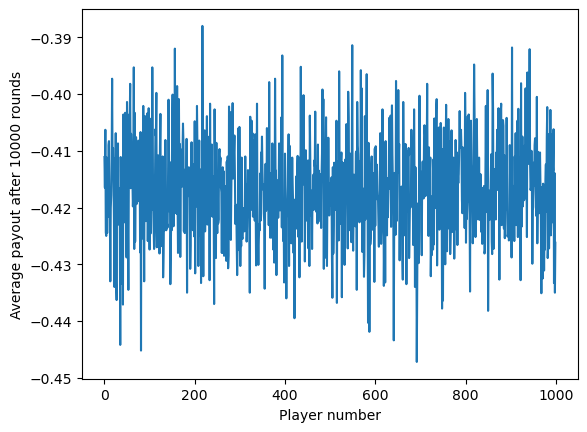

Average payout of a player after 10000 rounds is -0.4168651999999998


In [57]:
env = gym.make("Blackjack-v1", sab=True)
calc_payoffs(env, 10000, 1000, draw_till_20_pol)  # 1000 rounds, 1000 players

## Monte Carlo Method

Define functions to plot policy and value function.

In [76]:
def plot_policy(policy):

    def get_Z(player_hand, dealer_showing, usable_ace):
        if (player_hand, dealer_showing, usable_ace) in policy:
            return policy[player_hand, dealer_showing, usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        cbar.ax.invert_yaxis() 
            
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    plt.show()

In [60]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))


### MC (On-Policy)

In [93]:
def create_epsilon_greedy_action_policy(env,Q,epsilon):
    """ Create epsilon greedy action policy
    Args:
        env: Environment
        Q: Q table
        epsilon: Probability of selecting random action instead of the 'optimal' action
    
    Returns:
        Epsilon-greedy-action Policy function with Probabilities of each action for each state
    """
    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n  #initiate with same prob for all actions
        best_action = np.argmax(Q[obs])  #get best action
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

In [67]:
def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: Environment.
        episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state to action values.
        Policy is the trained policy that returns action probabilities
    """
    # Keeps track of sum and count of returns for each state
    # An array could be used to save all returns but that's memory inefficient.
    # defaultdict used so that the default value is stated if the observation(key) is not found
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    pol = create_epsilon_greedy_action_policy(env,Q,epsilon)
    
    for i in range(1, episodes + 1):
        # Print out which episode we're on
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")
            clear_output(wait=True)

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state, _ = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            #First Visit MC:
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
    
    return Q, pol

In [96]:
def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = create_epsilon_greedy_action_policy(env, Q, epsilon)

    # To store metrics
    episode_rewards = []
    episode_lengths = []
    training_errors = []

    for i in range(1, episodes + 1):
        if i % 1000 == 0:
            print(f"\rEpisode {i}/{episodes}.", end="")
            clear_output(wait=True)

        episode = []
        state, _ = env.reset()
        total_reward = 0
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _, _ = env.step(action)
            episode.append((state, action, reward))
            total_reward += reward
            if done:
                break
            state = next_state

        episode_rewards.append(total_reward)
        episode_lengths.append(len(episode))
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            first_occurrence_idx = next(j for j, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum(x[2]*(discount_factor**j) for j, x in enumerate(episode[first_occurrence_idx:]))
            returns_sum[(state, action)] += G
            returns_count[(state, action)] += 1.0
            new_value = returns_sum[(state, action)] / returns_count[(state, action)]
            training_error = (Q[state][action] - new_value)**2
            Q[state][action] = new_value
            training_errors.append(training_error)

    return Q, policy, episode_rewards, episode_lengths, training_errors

In [97]:
env = gym.make("Blackjack-v1", sab=True)
env.reset()
Q_on_pol,On_MC_Learned_Policy = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

Episode 500000/500000.

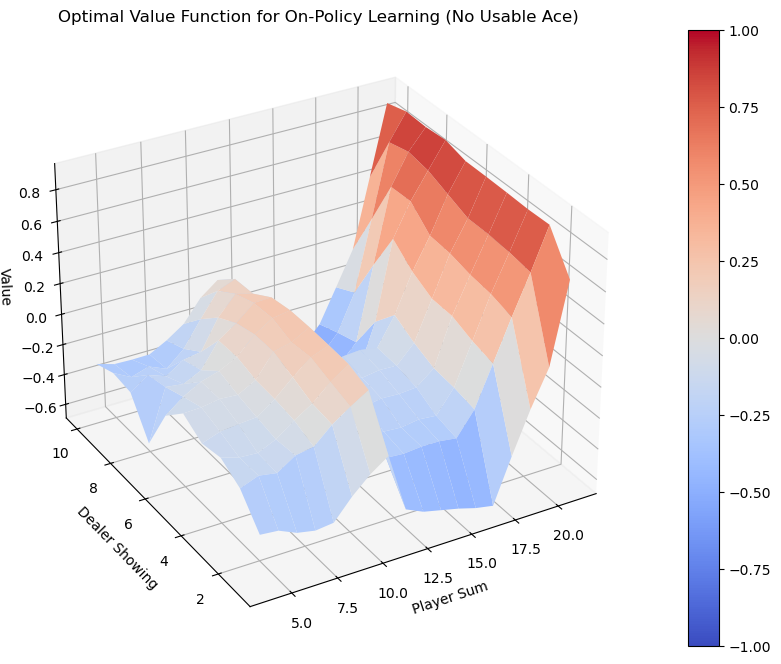

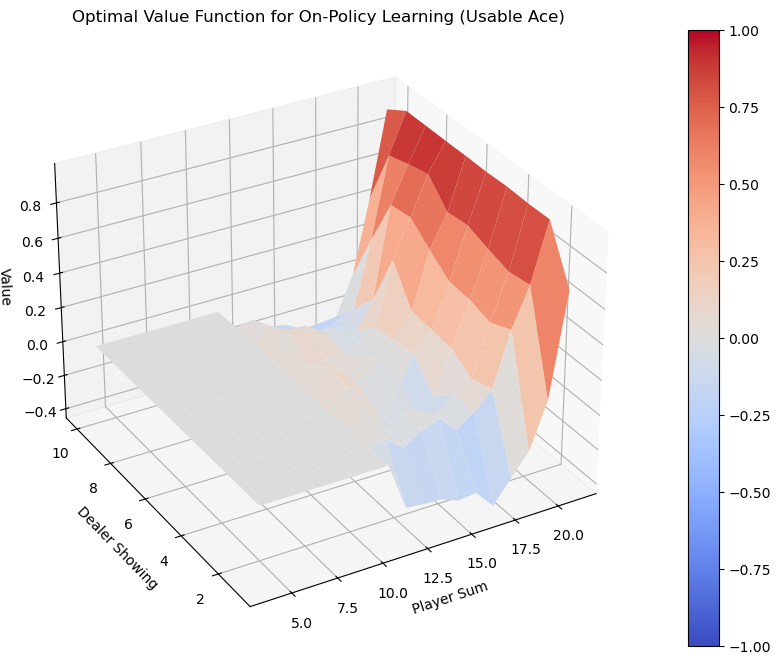

In [72]:
V = defaultdict(float)
for state, actions in Q_on_pol.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function for On-Policy Learning")

On-Policy MC Learning Policy


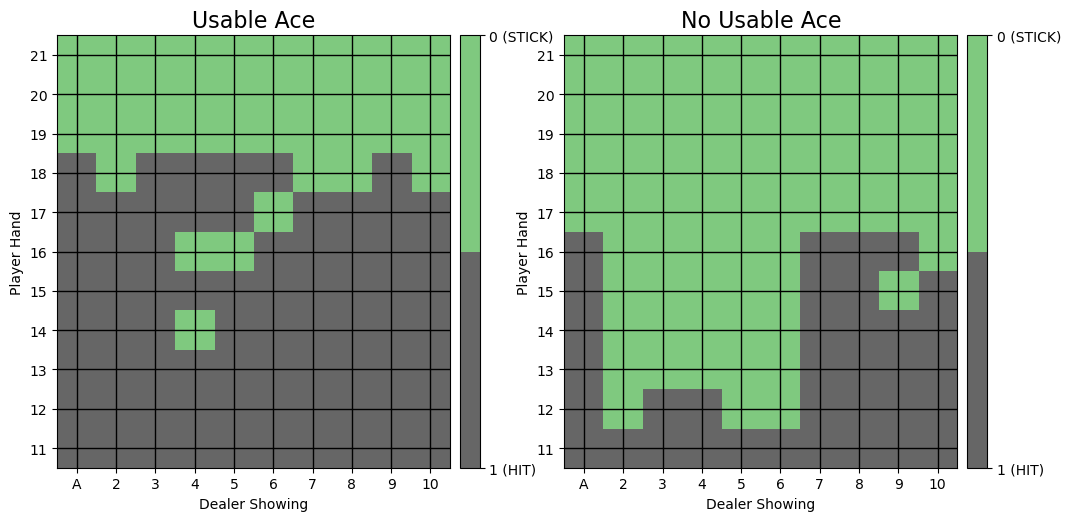

In [77]:
on_pol = {key: np.argmax(On_MC_Learned_Policy(key)) for key in Q_on_pol.keys()}
print("On-Policy MC Learning Policy")
plot_policy(on_pol)

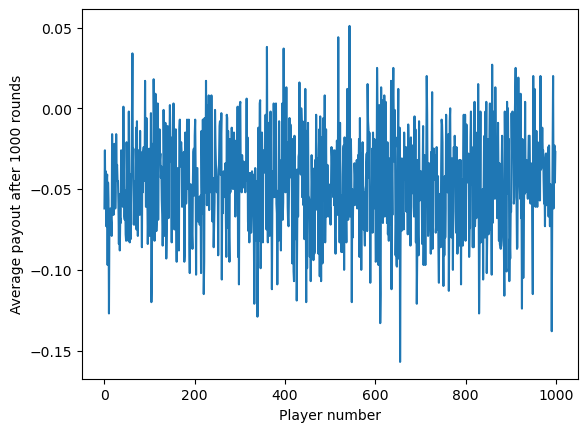

Average payout of a player after 1000 rounds is -0.04703499999999994


In [78]:
#Payoff for On-Policy MC Trained Policy
env.reset()
calc_payoffs(env,1000,1000,On_MC_Learned_Policy)

### MC (Off-Policy)

In [79]:
def create_random_policy(nA):
    """
    Creates a random policy function.

    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation state as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(obs):
        return A
    return policy_fn

def create_greedy_action_policy(env,Q):
    """ Create greedy action policy

    Args:
        env: Environment
        Q: Q table
    
    Returns:
        Greedy-action Policy function 
    """
    def policy(obs):
        P = np.zeros_like(Q[obs], dtype=float)
        best_action = np.argmax(Q[obs])  #get best action
        P[best_action] = 1
        return P
    return policy

def Off_pol_mc_control_learn(env, num_episodes, policy, discount_factor):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: Environment.
        num_episodes: Number of episodes to sample.
        policy: The policy to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedy policy 
    target_policy = create_greedy_action_policy(env,Q)
        
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            clear_output(wait=True)

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state, _ = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = target_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discount_factor * G + reward
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula 
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the policy is not the action 
            # taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./policy(state)[action]
        
    return Q, target_policy

In [80]:
env = gym.make("Blackjack-v1", sab=True)
env.reset()
rand = create_random_policy(env.action_space.n)
Q_off_Pol,off_MC_Learned_Policy = Off_pol_mc_control_learn(env, 500000, rand,0.9)

Episode 500000/500000.

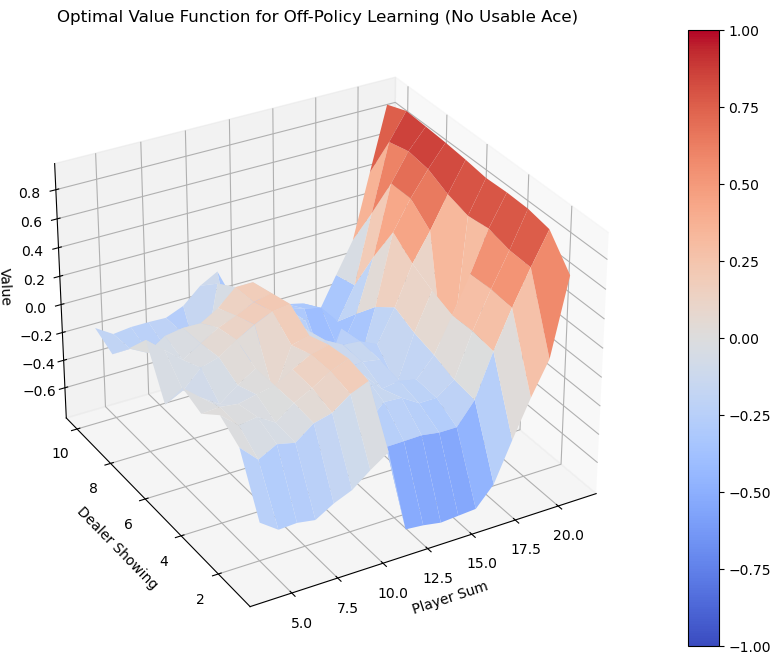

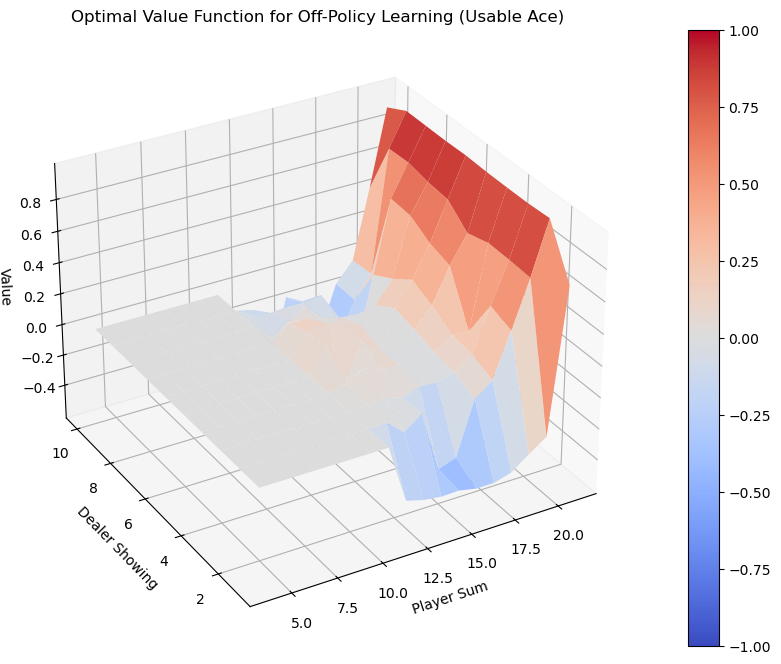

In [81]:
V = defaultdict(float)
for state, actions in Q_off_Pol.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function for Off-Policy Learning")

Off-Policy MC Learning Policy


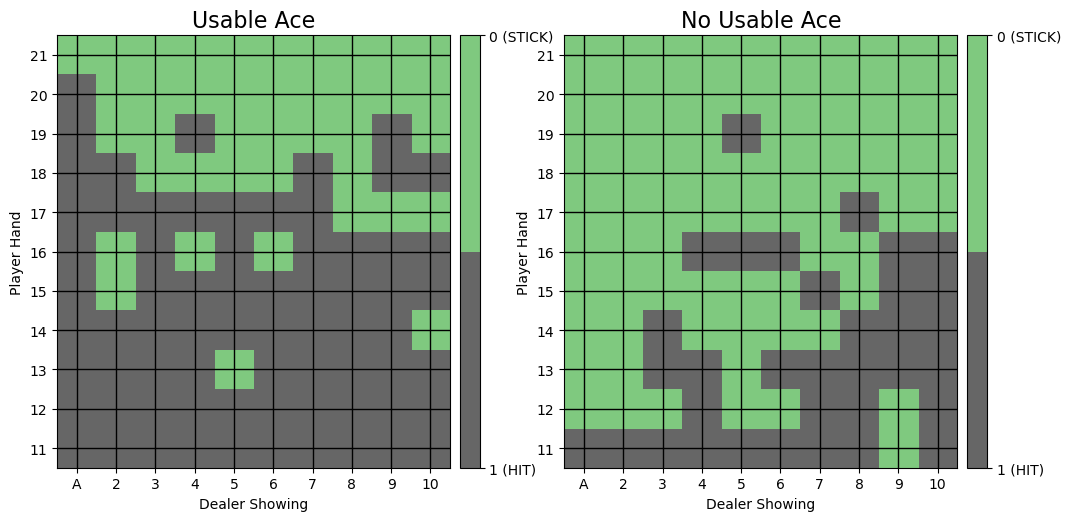

In [82]:
pol_test = {key: np.argmax(off_MC_Learned_Policy(key)) for key in Q_off_Pol.keys()}
print("Off-Policy MC Learning Policy")
plot_policy(pol_test)

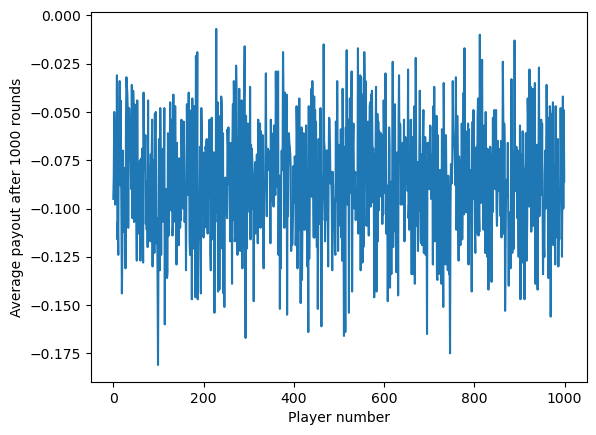

Average payout of a player after 1000 rounds is -0.08581499999999982


In [83]:
#Payoff for Off-Policy MC Trained Policy
env.reset()
calc_payoffs(env,1000,1000,off_MC_Learned_Policy)

## TD Learning

### SARSA Learning

In [84]:
def create_epsilon_greedy_action_policy(env, Q, epsilon):
    """ Create epsilon greedy action policy
    Args:
        env: Environment
        Q: Q table
        epsilon: Probability of selecting random action instead of the 'optimal' action
    
    Returns:
        Epsilon-greedy-action Policy function with Probabilities of each action for each state
    """
    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n  #initiate with same prob for all actions
        best_action = np.argmax(Q[obs])  #get best action
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

def SARSA(env, episodes, epsilon, alpha, gamma):
    """
    SARSA Learning Method
    
    Args:
        env: OpenAI gym environment.
        episodes: Number of episodes to sample.
        epsilon: Probability of selecting random action instead of the 'optimal' action
        alpha: Learning Rate
        gamma: Gamma discount factor
        
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. 
    """
    
    # Initialise a dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The policy we're following
    pol = create_epsilon_greedy_action_policy(env,Q,epsilon)
    for i in range(1, episodes + 1):
        # Print out which episode we're on
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")
            clear_output(wait=True)
        curr_state, _ = env.reset()
        probs = pol(curr_state)   #get epsilon greedy policy
        curr_act = np.random.choice(np.arange(len(probs)), p=probs)
        while True:
            next_state,reward,done,_, _ = env.step(curr_act)
            next_probs = create_epsilon_greedy_action_policy(env,Q,epsilon)(next_state)
            next_act = np.random.choice(np.arange(len(next_probs)),p=next_probs)
            td_target = reward + gamma * Q[next_state][curr_act]
            td_error = td_target - Q[curr_state][curr_act]
            Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
            if done:
                break
            curr_state = next_state
            curr_act = next_act
    return Q, pol

In [85]:
env = gym.make("Blackjack-v1", sab=True)
env.reset()
Q_SARSA,SARSA_Policy = SARSA(env, 500000, 0.1, 0.1,0.95)

Episode 500000/500000.

SARSA Learning Policy


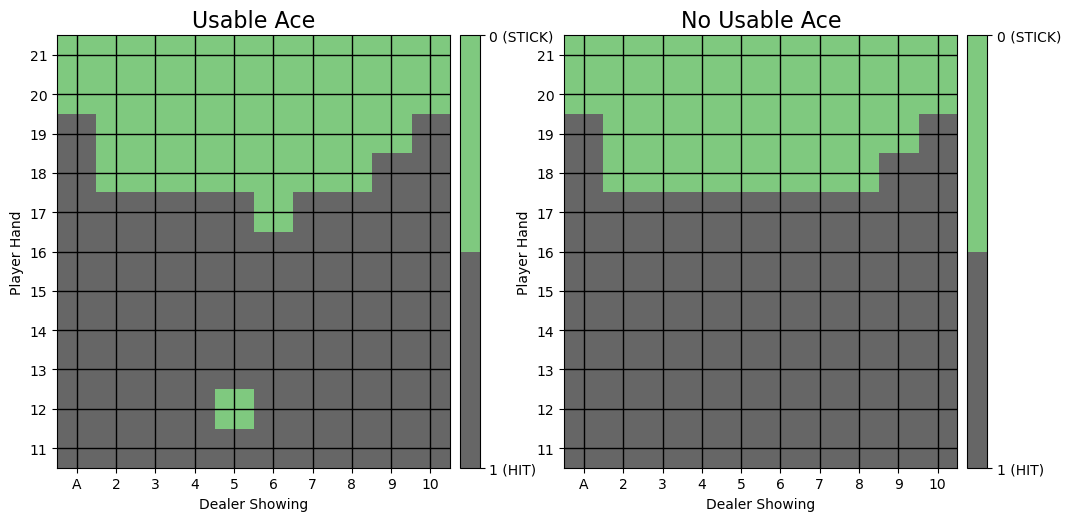

In [87]:
pol_sarsa = {key: np.argmax(SARSA_Policy(key)) for key in Q_SARSA.keys()}
print("SARSA Learning Policy")
plot_policy(pol_sarsa)

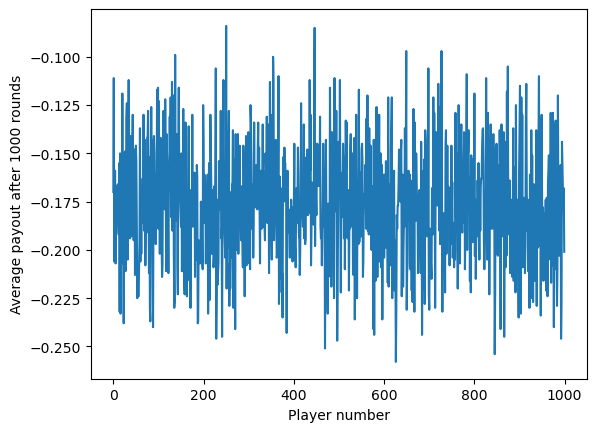

Average payout of a player after 1000 rounds is -0.1766130000000006


In [88]:
#Payoff for Off-Policy MC Trained Policy
env.reset()
calc_payoffs(env,1000,1000,SARSA_Policy)

### Q-Learning: Off-Policy TD

In [89]:
def off_pol_TD_Q_learn(env, episodes, epsilon, alpha, gamma):
    """
    Off-Policy TD Q-Learning Method
    
    Args:
        env: OpenAI gym environment.
        episodes: Number of episodes to sample.
        epsilon: Probability of selecting random action instead of the 'optimal' action
        alpha: Learning Rate
        gamma: Gamma discount factor
        
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. 
    """
    # Initialise a dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The policy we're following
    pol = create_epsilon_greedy_action_policy(env,Q,epsilon)
    for i in range(1, episodes + 1):
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")
            clear_output(wait=True)
        curr_state, _ = env.reset()
        while True:
            probs = pol(curr_state)   #get epsilon greedy policy
            curr_act = np.random.choice(np.arange(len(probs)), p=probs)
            next_state,reward,done,_, _ = env.step(curr_act)
            next_act = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][next_act]
            td_error = td_target - Q[curr_state][curr_act]
            Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
            if done:
                break
            curr_state = next_state
    return Q, pol

In [90]:
env = gym.make("Blackjack-v1", sab=True)
env.reset()
Q_QLearn,QLearn_Policy = off_pol_TD_Q_learn(env, 500000, 0.1, 0.1,0.95)

Episode 500000/500000.

Off-Policy Q Learning Policy


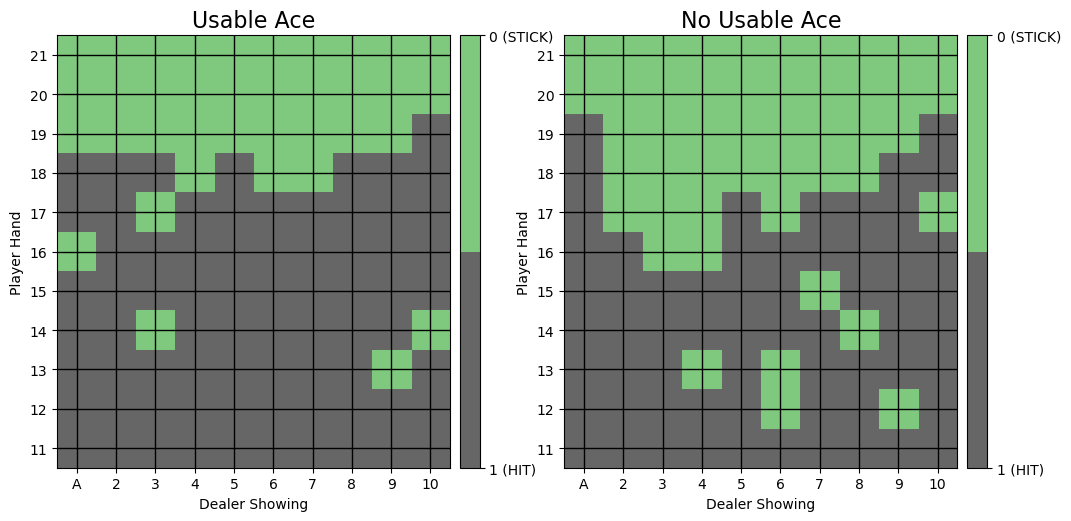

In [91]:
pol_QLearn = {key: np.argmax(QLearn_Policy(key)) for key in Q_QLearn.keys()}
print("Off-Policy Q Learning Policy")
plot_policy(pol_QLearn)

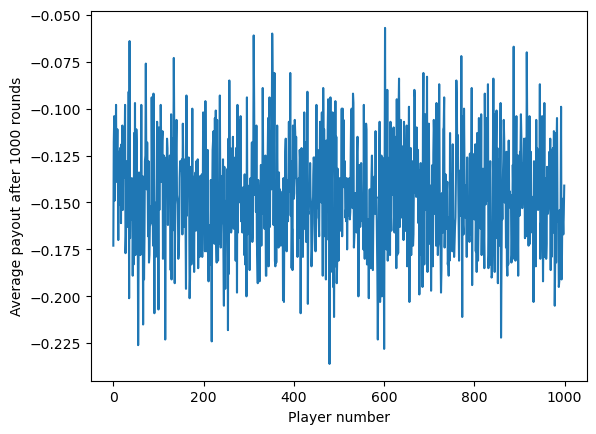

Average payout of a player after 1000 rounds is -0.14612800000000026


In [92]:
#Payoff for Off-Policy Q-Learning Trained Policy
env.reset()
calc_payoffs(env,1000,1000,QLearn_Policy)